# Final Project: Dota 2

## Import libraries

In [2]:
import pandas
import numpy
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics
import time 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [4]:
data = pandas.read_csv('YandexCourse/w7/features.csv')

In [7]:
data.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,4,2,2,-52,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,4,3,1,-5,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,4,3,1,13,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,4,2,0,27,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,3,3,0,-16,2449,0,4,1974,3,63


## Get output column

In [6]:
y = data['radiant_win']

## Drop features which are absent in test data

In [8]:
data = data.drop(['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 
           'barracks_status_dire'], axis=1)

## Get features with missed values

In [6]:
columns_with_misses = []
for column in data.columns:
    if data[column].count() != len(data):
        columns_with_misses.append(column)
print columns_with_misses

['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']


We can see that some features that associated with events which might not happen in first 5 minutes of the game has some missed values. For example, all 4 feautures related to "first blood" event has missed values.

(In russian): Мы можем видеть, что некоторые признаки, которые связаны с событиями, которые могут и не произойти в первые пять минут имеют пропущенные значения. Например, все четыре признака, связанные с событием "Первая кровь" имеют пропущенные значения.

## Fill missed values with zeros

In [9]:
data = data.fillna(0)

## Prepare k-fold 

In [10]:
kfold = sklearn.cross_validation.KFold(len(data), n_folds=5, shuffle=True, random_state=0)

# Gradient Boosting

## Choose number of estimators

In [21]:
clf = sklearn.ensemble.GradientBoostingClassifier(random_state=0, max_depth=3)
for n in [1, 5, 10, 20, 30]:
    starttime = datetime.datetime.now()
    clf.n_estimators = n
    scores = sklearn.cross_validation.cross_val_score(clf, data, y, cv=kfold, scoring='roc_auc')
    print 'Time elapsed for %i estimators:'%n, datetime.datetime.now() - starttime
    print 'Score for %i estimators:'%n, scores.mean()

Time elapsed for 1 estimators: 0:00:27.885000
Score for 1 estimators: 0.59728480855
Time elapsed for 5 estimators:

 0:01:51.621000
Score for 5 estimators: 0.6346644138
Time elapsed for 10 estimators:

 0:03:39.322000
Score for 10 estimators: 0.663717389719
Time elapsed for 20 estimators:

 0:07:51.050000
Score for 20 estimators: 0.681722158281
Time elapsed for 30 estimators:

 0:11:25.824000
Score for 30 estimators: 0.688614863733


## Check if 30 trees is enough

In [35]:
clf.n_estimators = 400
clf.max_depth = 3
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(data, y,
                                      test_size=0.3,
                                      random_state=241)

starttime = datetime.datetime.now()
clf.fit(X_train, y_train)
print 'Time elapsed for fitting %i trees:'%clf.n_estimators, datetime.datetime.now() - starttime

scores = []
for i, pred in enumerate(clf.staged_decision_function(X_test)):
    scores.append(sklearn.metrics.roc_auc_score(y_test, pred) )

Time elapsed for fitting 400 trees: 0:21:34.967000


In [37]:
scores_train = []
for i, pred in enumerate(clf.staged_decision_function(X_train)):
    scores_train.append(sklearn.metrics.roc_auc_score(y_train, pred) )

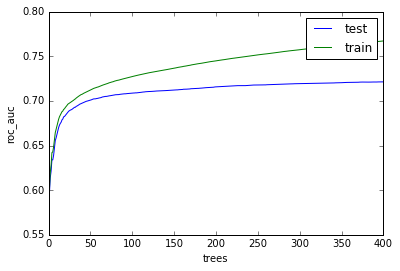

roc_auc score on 30 trees on test data: 0.691975966821
roc_auc score on 400 trees on test data: 0.721292910462


In [39]:
x = range(1, len(scores) + 1)
plt.plot(x, scores)
plt.plot(x, scores_train, 'g')
plt.legend(['test','train'])
plt.xlabel('trees')
plt.ylabel('roc_auc')
plt.show()
print "roc_auc score on 30 trees on test data:", scores[29]
print "roc_auc score on 400 trees on test data:", scores[-1]

We could get significally better model with more than 30 trees.

# Logistic Regression

## Scale features

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data)

## Choose regularization strength

In [12]:
clfLR = sklearn.linear_model.LogisticRegression(penalty='l2', random_state=0)

Cset = numpy.logspace(-4, 4, 9)

res = {}
for C in Cset:
    clfLR.C = C
    scores = sklearn.cross_validation.cross_val_score(clfLR, scaled_data, y, cv=kfold, scoring='roc_auc')
    res[C] = scores.mean()
print res

{1.0: 0.71627928251428052, 100.0: 0.71627848521500448, 0.10000000000000001: 0.71628354241827574, 1000.0: 0.71627848521205528, 10.0: 0.71627861226315304, 0.001: 0.7161639862006195, 0.0001: 0.71123252316501495, 10000.0: 0.7162784979192548, 0.01: 0.71631595836318263}


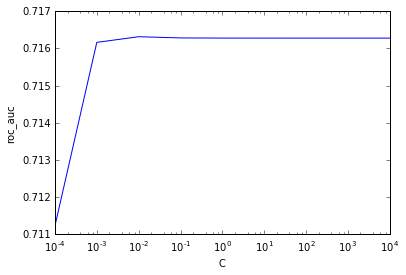

In [13]:
res_values = []
for C in Cset:
    res_values.append(res[C])

plt.plot(Cset, res_values)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('roc_auc')
plt.show()

The best model has C = 0.01 with quality roc_auc = 0.716315958363

## Remove categorical features for logistic classification

In [ ]:
scaled_data = pandas.DataFrame(scaled_data, columns = data.columns)
scaled_data.drop(['lobby_type','r1_hero', 'r2_hero','r3_hero','r4_hero', 'r5_hero',  
                  'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'],
                 axis=1, inplace=True)

## Calculate score on dataset without categorical features

In [17]:
clfLR.C = 0.01
scores = sklearn.cross_validation.cross_val_score(clfLR, scaled_data, y, cv=kfold, scoring='roc_auc')
print scores.mean()

0.716377624513


We have got the same perfomance as on full dataset. That means that categorical features in current form don't help classifier to make predictions. We should transform these features.

## Calculate heroes ids

In [26]:
heroes = data['r1_hero'].copy()
heroes = heroes.append(data['r2_hero'])
heroes = heroes.append(data['r3_hero'])
heroes = heroes.append(data['r4_hero'])
heroes = heroes.append(data['r5_hero'])
heroes = heroes.append(data['d1_hero'])
heroes = heroes.append(data['d2_hero'])
heroes = heroes.append(data['d3_hero'])
heroes = heroes.append(data['d4_hero'])
heroes = heroes.append(data['d5_hero'])

In [31]:
print heroes.shape
print 'Unique heros in the current dataset: ', len(heroes.unique())
print 'range of heroes ids: %i - %i'%(heroes.min(), heroes.max())

(972300L,)
Unique heros in the current dataset:  108
range of heroes ids: 1 - 112

## Transform categorical information about heroes

In [37]:
Xpick = numpy.zeros((data.shape[0], 112))
for i, matchid in enumerate(data.index):
    for p in xrange(5):
        Xpick[i, data.ix[matchid, 'r%d_hero' % (p+1)]-1] = 1
        Xpick[i, data.ix[matchid, 'd%d_hero' % (p+1)]-1] = -1

In [42]:
pdX = pandas.DataFrame( Xpick, columns=['hero_%i'%x for x in range(1,113)])
full_data = scaled_data.join(pdX)
print full_data.shape

(97230, 204)


In [46]:
clfLR = sklearn.linear_model.LogisticRegression(penalty='l2', random_state=0)

Cset = numpy.logspace(-4, 4, 9)

res = []
for C in Cset:
    clfLR.C = C
    scores = sklearn.cross_validation.cross_val_score(clfLR, full_data, y, cv=kfold, scoring='roc_auc')
    res.append(scores.mean())
print res

plt.plot(Cset, res)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('roc_auc')
plt.show()

## Calculate roc-auc score based on probability predictions

In [47]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(full_data, y,
                                      test_size=0.3,
                                      random_state=241)
clfLR.C = 0.1
clfLR.fit(X_train, y_train)

In [55]:
pred = clfLR.predict_proba(X_test)
print "aur-roc score: %f"%sklearn.metrics.roc_auc_score(y_test, pred[:,1])

aur-roc score: 0.753426
